In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
df = pd.read_csv('../../Dataset/MyMethod/EntireBoulderWithWeather.csv')
df.head()

,Unnamed: 0,ObjectId2,Station_Name,Address,City,State_Province,Zip_Postal_Code,Start_Date___Time,Start_Time_Zone,End_Date___Time,...,ObjectID,Date,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow,Weekday
0,0,1,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018-01-01 17:49:00,MDT,2018-01-01 19:52:00,...,0,2018-01-01,2018,January,1,30,12,0.0,0.0,Monday
1,2,3,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018-01-02 21:11:00,MDT,2018-01-03 06:23:00,...,2,2018-01-02,2018,January,2,46,12,0.0,0.0,Tuesday
2,3,70196,BOULDER / JUNCTION ST1,2280 Junction Pl,Boulder,Colorado,80301,2018-01-02 08:52:00,MDT,2018-01-02 09:16:00,...,1,2018-01-02,2018,January,2,46,12,0.0,0.0,Tuesday
3,6,4,BOULDER / ALPINE ST1,1275 Alpine Ave,Boulder,Colorado,80304,2018-01-03 09:19:00,MDT,2018-01-03 11:14:00,...,3,2018-01-03,2018,January,3,50,20,0.0,0.0,Wednesday
4,7,5,BOULDER / BASELINE ST1,900 Baseline Rd,Boulder,Colorado,80302,2018-01-03 14:13:00,MDT,2018-01-03 14:30:00,...,4,2018-01-03,2018,January,3,50,20,0.0,0.0,Wednesday


- Charge and/or Park Duration has to be positive and less than 24 h (1440 min).
- Energy Consumption needs to be positive and less than 100 kWh. The 100 kWh upper bound was chosen as it is close to the highest capacity
of the Tesla Model S which is the EV with the largest battery capacity amongst the most
widespread models.

In [3]:
columns_to_keep = ['Station_Name','Start_Date___Time', 'Total_Duration__hh_mm_ss_','Charging_Time__hh_mm_ss_','Energy__kWh_','Date', 'Year', 'Month','Day', 
                   'Maximum T', 'Minimum T', 'Precipitation', 'Snow', 'Weekday']

df = df[columns_to_keep]
df.head()

,Station_Name,Start_Date___Time,Total_Duration__hh_mm_ss_,Charging_Time__hh_mm_ss_,Energy__kWh_,Date,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow,Weekday
0,BOULDER / JUNCTION ST1,2018-01-01 17:49:00,0 days 02:03:02,0 days 02:02:44,6.504,2018-01-01,2018,January,1,30,12,0.0,0.0,Monday
1,BOULDER / JUNCTION ST1,2018-01-02 21:11:00,0 days 09:12:21,0 days 03:40:52,15.046,2018-01-02,2018,January,2,46,12,0.0,0.0,Tuesday
2,BOULDER / JUNCTION ST1,2018-01-02 08:52:00,0 days 00:24:34,0 days 00:24:19,2.481,2018-01-02,2018,January,2,46,12,0.0,0.0,Tuesday
3,BOULDER / ALPINE ST1,2018-01-03 09:19:00,0 days 01:54:51,0 days 01:54:29,6.947,2018-01-03,2018,January,3,50,20,0.0,0.0,Wednesday
4,BOULDER / BASELINE ST1,2018-01-03 14:13:00,0 days 00:16:58,0 days 00:16:44,1.800,2018-01-03,2018,January,3,50,20,0.0,0.0,Wednesday


In [4]:
df.isna().sum()[df.isna().sum()>0]

Series([], dtype: int64)

In [5]:
print(df.shape)

# Convert 'Total_Duration__hh_mm_ss_' and 'Charging_Time__hh_mm_ss_' to timedelta
df['Total_Duration__hh_mm_ss_'] = pd.to_timedelta(df['Total_Duration__hh_mm_ss_'])
df['Charging_Time__hh_mm_ss_'] = pd.to_timedelta(df['Charging_Time__hh_mm_ss_'])

# Convert 'Charging_Time__hh_mm_ss_' to minutes for easier comparisons
df['Charging_Time_min'] = df['Charging_Time__hh_mm_ss_'].dt.total_seconds() / 60

# Filter based on charging time between 5 and 1440 minutes
df = df[(df['Charging_Time_min'] >= 5) & (df['Charging_Time_min'] <= 1440)]

# Calculate 'Remaining_Park_After_Charge_(min)'
df['Remaining_Park_After_Charge_(min)'] = ((df['Total_Duration__hh_mm_ss_'] - df['Charging_Time__hh_mm_ss_']).dt.total_seconds() / 60).round(2)

# Filter based on remaining park time between 0 and 1440 minutes
df = df[(df['Remaining_Park_After_Charge_(min)'] >= 0) & (df['Remaining_Park_After_Charge_(min)'] <= 1440)]

# Filter based on positive and less than 100 kWh energy consumption
df = df[(df['Energy__kWh_'] >= 0) & (df['Energy__kWh_'] <= 100)]

# Drop the intermediate columns if not needed
df = df.drop(columns=['Total_Duration__hh_mm_ss_', 'Charging_Time__hh_mm_ss_'])

print(df.shape)

(69061, 14)
(66966, 14)


In [6]:
df[['Energy__kWh_', 'Charging_Time_min']].describe()

,Energy__kWh_,Charging_Time_min
count,66966.000000,66966.000000
mean,9.664680,117.587162
std,8.762833,95.261648
min,0.001000,5.000000
25%,4.170000,57.866667
50%,7.190000,94.283333
75%,12.299000,145.412500
max,92.691000,1420.733333


In [7]:
df.isna().sum()

Station_Name                         0
Start_Date___Time                    0
Energy__kWh_                         0
Date                                 0
Year                                 0
Month                                0
Day                                  0
Maximum T                            0
Minimum T                            0
Precipitation                        0
Snow                                 0
Weekday                              0
Charging_Time_min                    0
Remaining_Park_After_Charge_(min)    0
dtype: int64

In [8]:
sorted(df['Station_Name'].unique())

['BOULDER / AIRPORT ST1',
 'BOULDER / ALPINE ST1',
 'BOULDER / ANNEX ST1',
 'BOULDER / ATRIUM ST1',
 'BOULDER / BASELINE ST1',
 'BOULDER / BOULDER PARK S1',
 'BOULDER / BOULDER PARK S2',
 'BOULDER / CARPENTER PARK1',
 'BOULDER / CARPENTER PARK2',
 'BOULDER / EAST REC',
 'BOULDER / FACILITIES ST1',
 'BOULDER / FLT MNT E1',
 'BOULDER / FLT MNT E2',
 'BOULDER / FLT MNT E3',
 'BOULDER / FLT MNT E4',
 'BOULDER / FLT MNT E6',
 'BOULDER / FLT MNT E7',
 'BOULDER / FLT MNT E8',
 'BOULDER / JUNCTION ST1',
 'BOULDER / MSC E1',
 'BOULDER / MSC E2',
 'BOULDER / N BOULDER REC 1',
 'BOULDER / OSMP FLEET 1',
 'BOULDER / OSMP FLEET 2',
 'BOULDER / REC CENTER ST1',
 'BOULDER / REC CENTER ST2',
 'BOULDER / RESERVOIR ST1',
 'BOULDER / RESERVOIR ST2',
 'BOULDER / VALMONT ST1',
 'BOULDER / VALMONT ST2',
 'BOULDERJUNCTION / JUNCTION ST1',
 'COMM VITALITY / 1000WALNUT1',
 'COMM VITALITY / 1000WALNUT2',
 'COMM VITALITY / 1100WALNUT1',
 'COMM VITALITY / 1104 SPRUCE1',
 'COMM VITALITY / 1400 WALNUT1',
 'COMM VIT

In [9]:
df.sort_values(by='Start_Date___Time', inplace=True)
df.Start_Date___Time.is_monotonic_increasing

True

In [10]:
def group_generator(df, group_cols=['Station_Name']):
    grouped_df = df.groupby(group_cols)
    for idx, transactions in grouped_df:
        yield idx, transactions.copy().sort_values(by='Start_Date___Time')

stations_df = df[['Station_Name']].drop_duplicates().reset_index(drop=True)
stations_df['Transactions'] = None

for idx, transactions_df in group_generator(df):
    Station_Name = idx
    mask = (stations_df['Station_Name'] == Station_Name)

    stations_df.loc[mask, 'Transactions'] = [transactions_df.loc[:, transactions_df.columns].copy()]


stations_df['Transactions'].apply(lambda x: x['Start_Date___Time'].is_monotonic_increasing).all()

True

In [11]:
null_count = stations_df['Transactions'].apply(lambda x: x.isna().sum())
total_nulls = null_count.sum()

print(f"Total null values in 'Transactions' column: {total_nulls}")

Total null values in 'Transactions' column: Station_Name                         0
Start_Date___Time                    0
Energy__kWh_                         0
Date                                 0
Year                                 0
Month                                0
Day                                  0
Maximum T                            0
Minimum T                            0
Precipitation                        0
Snow                                 0
Weekday                              0
Charging_Time_min                    0
Remaining_Park_After_Charge_(min)    0
dtype: int64


In [12]:
stations_df.loc[0,'Transactions'].head()

,Station_Name,Start_Date___Time,Energy__kWh_,Date,Year,Month,Day,Maximum T,Minimum T,Precipitation,Snow,Weekday,Charging_Time_min,Remaining_Park_After_Charge_(min)
0,BOULDER / JUNCTION ST1,2018-01-01 17:49:00,6.504,2018-01-01,2018,January,1,30,12,0.0,0.0,Monday,122.733333,0.30
2,BOULDER / JUNCTION ST1,2018-01-02 08:52:00,2.481,2018-01-02,2018,January,2,46,12,0.0,0.0,Tuesday,24.316667,0.25
1,BOULDER / JUNCTION ST1,2018-01-02 21:11:00,15.046,2018-01-02,2018,January,2,46,12,0.0,0.0,Tuesday,220.866667,331.48
9,BOULDER / JUNCTION ST1,2018-01-04 20:16:00,16.744,2018-01-04,2018,January,4,52,24,0.0,0.0,Thursday,243.650000,424.63
11,BOULDER / JUNCTION ST1,2018-01-04 21:11:00,3.476,2018-01-04,2018,January,4,52,24,0.0,0.0,Thursday,41.333333,0.37


In [13]:
# Stations Daily
print(len(stations_df.loc[0,'Transactions']))
stations_daily = stations_df.copy()
stations_daily['Transactions'] = stations_df['Transactions'].apply(lambda x: x.groupby('Date').agg({
    'Energy__kWh_': 'sum',
    'Year': 'first',  # Take the first value for the 'Year' column
    'Month': 'first',
    'Weekday': 'first',    
    'Maximum T': 'sum',
    'Minimum T': 'sum',
    'Precipitation': 'sum',
    'Snow': 'sum',
    'Charging_Time_min': 'sum',
    'Remaining_Park_After_Charge_(min)': 'sum' }))

stations_daily = stations_daily.reset_index(drop=True)
print(len(stations_daily.loc[0,'Transactions']))

381
265


In [14]:
null_count = stations_daily['Transactions'].apply(lambda x: x.isna().sum())
total_nulls = null_count.sum()

print(f"Total null values in 'Transactions' column: {total_nulls}")

Total null values in 'Transactions' column: Energy__kWh_                         0
Year                                 0
Month                                0
Weekday                              0
Maximum T                            0
Minimum T                            0
Precipitation                        0
Snow                                 0
Charging_Time_min                    0
Remaining_Park_After_Charge_(min)    0
dtype: int64


In [15]:
stations_daily.loc[0,'Transactions']

,Energy__kWh_,Year,Month,Weekday,Maximum T,Minimum T,Precipitation,Snow,Charging_Time_min,Remaining_Park_After_Charge_(min)
Date,,,,,,,,,,
2018-01-01,6.504,2018,January,Monday,30,12,0.00000,0.0,122.733333,0.30
2018-01-02,17.527,2018,January,Tuesday,92,24,0.00000,0.0,245.183333,331.73
2018-01-04,20.220,2018,January,Thursday,104,48,0.00000,0.0,284.983333,425.00
2018-01-06,10.224,2018,January,Saturday,60,30,0.00000,0.0,200.550000,187.47
2018-01-10,10.348,2018,January,Wednesday,59,44,0.25400,0.0,103.033333,0.18
...,...,...,...,...,...,...,...,...,...,...
2019-07-26,17.668,2019,July,Friday,276,168,0.00000,0.0,239.633333,9.11
2019-07-30,3.107,2019,July,Tuesday,90,56,2.79400,0.0,31.216667,0.33
2019-07-31,3.802,2019,July,Wednesday,87,63,0.25400,0.0,72.083333,0.22


In [16]:
stations_daily['Transactions'].apply(lambda x: len(x)).sort_values().head(5)

47    1
46    1
40    1
41    2
48    4
Name: Transactions, dtype: int64

In [17]:
len(stations_daily['Transactions'].apply(lambda x: len(x))[stations_daily['Transactions'].apply(lambda x: len(x))>0].sort_values(ascending=True))

49

In [18]:
len(stations_daily['Transactions'].apply(lambda x: len(x))[stations_daily['Transactions'].apply(lambda x: len(x))>30].sort_values(ascending=True))

39

In [19]:
stations_daily = stations_daily[stations_daily['Transactions'].apply(lambda x: len(x)) > 30]
stations_daily = stations_daily.reset_index(drop=True)
len(stations_daily)

39

In [20]:
stations_daily['Transactions'].apply(lambda x: len(x)).sort_values().head(5)

27    32
31    49
30    77
18    88
21    92
Name: Transactions, dtype: int64

In [21]:
stations_daily.loc[0,'Transactions']

,Energy__kWh_,Year,Month,Weekday,Maximum T,Minimum T,Precipitation,Snow,Charging_Time_min,Remaining_Park_After_Charge_(min)
Date,,,,,,,,,,
2018-01-01,6.504,2018,January,Monday,30,12,0.00000,0.0,122.733333,0.30
2018-01-02,17.527,2018,January,Tuesday,92,24,0.00000,0.0,245.183333,331.73
2018-01-04,20.220,2018,January,Thursday,104,48,0.00000,0.0,284.983333,425.00
2018-01-06,10.224,2018,January,Saturday,60,30,0.00000,0.0,200.550000,187.47
2018-01-10,10.348,2018,January,Wednesday,59,44,0.25400,0.0,103.033333,0.18
...,...,...,...,...,...,...,...,...,...,...
2019-07-26,17.668,2019,July,Friday,276,168,0.00000,0.0,239.633333,9.11
2019-07-30,3.107,2019,July,Tuesday,90,56,2.79400,0.0,31.216667,0.33
2019-07-31,3.802,2019,July,Wednesday,87,63,0.25400,0.0,72.083333,0.22


In [22]:
stations_daily['Station_Name']

0             BOULDER / JUNCTION ST1
1               BOULDER / ALPINE ST1
2             BOULDER / BASELINE ST1
3           BOULDER / FACILITIES ST1
4         COMM VITALITY / 1500PEARL2
5               BOULDER / ATRIUM ST1
6           BOULDER / REC CENTER ST2
7        COMM VITALITY / 1000WALNUT2
8           BOULDER / REC CENTER ST1
9         COMM VITALITY / 1500PEARL1
10      COMM VITALITY / 1400 WALNUT1
11       COMM VITALITY / 1000WALNUT1
12      COMM VITALITY / 1104 SPRUCE1
13      COMM VITALITY / BOULDER JCTN
14       COMM VITALITY / 1100WALNUT1
15         BOULDER / BOULDER PARK S2
16         BOULDER / N BOULDER REC 1
17         BOULDER / BOULDER PARK S1
18    COMM VITALITY / 2200 BROADWAY1
19                BOULDER / EAST REC
20               BOULDER / ANNEX ST1
21    BOULDERJUNCTION / JUNCTION ST1
22           BOULDER / RESERVOIR ST1
23           BOULDER / RESERVOIR ST2
24         BOULDER / CARPENTER PARK1
25         BOULDER / CARPENTER PARK2
26             BOULDER / AIRPORT ST1
2

In [23]:
# Define a function to add missing dates for a single row
def add_missing_dates(row):
    start_date = row['Transactions'].index.min()
    end_date = row['Transactions'].index.max()
    date_range = pd.date_range(start_date, end_date, freq='D')

    # Create a DataFrame with the desired date range
    new_dates_df = pd.DataFrame(index=date_range)

    # Check for dates that are not already present in 'Transactions'
    missing_dates = new_dates_df[~new_dates_df.index.isin(row['Transactions'].index)]

    # Merge the original DataFrame with the missing dates using left join
    merged_df = pd.concat([row['Transactions'], missing_dates])

    # Convert the index to datetime and sort it
    merged_df.index = pd.to_datetime(merged_df.index).date
    merged_df = merged_df.sort_index()

    return {'Station_Name': row['Station_Name'], 'Transactions': merged_df}


# Apply the function to each row of the DataFrame
processed_data = stations_daily.apply(lambda row: add_missing_dates(row), axis=1)

# Create a new DataFrame with the processed data
stations_daily = pd.DataFrame(processed_data.tolist())

In [24]:
stations_daily['Transactions'].apply(lambda x: len(x)).sort_values().head(5)

37    142
33    144
38    163
21    180
36    213
Name: Transactions, dtype: int64

In [25]:
# Check for duplicate indexes
duplicates = stations_daily.index.duplicated(keep=False)

# Print the rows with duplicate indexes
if any(duplicates):
    duplicated_rows = stations_daily[duplicates]
    print("Rows with duplicate indexes:")
    print(duplicated_rows)
else:
    print("No duplicate indexes found.")

No duplicate indexes found.


Source: https://web1.eng.famu.fsu.edu/~dommelen/courses/eml3100/aids/intpol/

In [26]:
stations_daily.loc[0,'Transactions']

,Energy__kWh_,Year,Month,Weekday,Maximum T,Minimum T,Precipitation,Snow,Charging_Time_min,Remaining_Park_After_Charge_(min)
2018-01-01,6.504,2018.0,January,Monday,30.0,12.0,0.00000,0.0,122.733333,0.30
2018-01-02,17.527,2018.0,January,Tuesday,92.0,24.0,0.00000,0.0,245.183333,331.73
2018-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,20.220,2018.0,January,Thursday,104.0,48.0,0.00000,0.0,284.983333,425.00
2018-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2019-08-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-08-05,8.747,2019.0,August,Monday,89.0,63.0,0.00000,0.0,85.716667,0.60
2019-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
def linear_interpolation(g, g1, g2, d1, d2):
    """
    Linear Interpolation Function

    Parameters:
    - g: The desired input value for which you want to interpolate the corresponding output value.
    - g1: The lower bound of the known input values.
    - g2: The upper bound of the known input values.
    - d1: The output value corresponding to the lower bound input value (g1).
    - d2: The output value corresponding to the upper bound input value (g2).

    Returns:
    - The interpolated output value corresponding to the desired input value (g).
    """
    return d1 + ((g - g1) * (d2 - d1) / (g2 - g1))


def interpolate_missing_values(row, columns_to_interpolate):
    for column in columns_to_interpolate:
        null_values = row['Transactions'][row['Transactions'].isnull().any(axis=1)]
        null_indexes = null_values.index.to_list()

        while len(null_indexes) > 0:

            predict_date = null_indexes.pop(0) # (The g in interpolate)
            prev_date = row['Transactions'].loc[:predict_date].dropna().iloc[-1].name # The previous past date without null values (The g1 in interpolate)
            next_date = row['Transactions'].loc[predict_date:].dropna().iloc[0].name # (The g2 in interpolate)

            d1 = pd.to_numeric(row['Transactions'].loc[prev_date, column], errors='coerce')
            d2 = pd.to_numeric(row['Transactions'].loc[next_date, column], errors='coerce')
            
            row['Transactions'].loc[predict_date, column] = linear_interpolation(predict_date, prev_date, next_date, d1, d2)

    return row
    
# List of columns to interpolate
columns_to_interpolate = ['Energy__kWh_', 'Maximum T', 'Minimum T', 'Precipitation', 'Snow', 'Charging_Time_min', 'Remaining_Park_After_Charge_(min)']

# Apply the function to each row in the DataFrame
stations_daily = stations_daily.apply(lambda row: interpolate_missing_values(row, columns_to_interpolate), axis=1)

In [28]:
stations_daily.loc[0,'Transactions']

,Energy__kWh_,Year,Month,Weekday,Maximum T,Minimum T,Precipitation,Snow,Charging_Time_min,Remaining_Park_After_Charge_(min)
2018-01-01,6.5040,2018.0,January,Monday,30.0,12.0,0.00000,0.0,122.733333,0.300
2018-01-02,17.5270,2018.0,January,Tuesday,92.0,24.0,0.00000,0.0,245.183333,331.730
2018-01-03,18.8735,NaN,NaN,NaN,98.0,36.0,0.00000,0.0,265.083333,378.365
2018-01-04,20.2200,2018.0,January,Thursday,104.0,48.0,0.00000,0.0,284.983333,425.000
2018-01-05,15.2220,NaN,NaN,NaN,82.0,39.0,0.00000,0.0,242.766667,306.235
...,...,...,...,...,...,...,...,...,...,...
2019-08-03,6.7690,NaN,NaN,NaN,88.2,63.0,0.10160,0.0,80.263333,0.448
2019-08-04,7.7580,NaN,NaN,NaN,88.6,63.0,0.05080,0.0,82.990000,0.524
2019-08-05,8.7470,2019.0,August,Monday,89.0,63.0,0.00000,0.0,85.716667,0.600
2019-08-06,9.9035,NaN,NaN,NaN,88.5,63.0,0.12573,0.0,116.650000,0.365


In [29]:
def fill_in_the_missing_date_columns(row):
    for i in range(len(row['Transactions'])):
        date = row['Transactions'].index[i]
        row['Transactions'].loc[date, 'Year'] = date.year
        row['Transactions'].loc[date, 'Month'] = date.strftime('%B')
        row['Transactions'].loc[date, 'Weekday'] = date.strftime('%A')

    return row

stations_daily = stations_daily.apply(lambda row: fill_in_the_missing_date_columns(row), axis=1)

stations_daily['Transactions'].apply(lambda x: x.index.is_monotonic_increasing).all()

True

In [30]:
stations_daily.loc[0,'Transactions']

,Energy__kWh_,Year,Month,Weekday,Maximum T,Minimum T,Precipitation,Snow,Charging_Time_min,Remaining_Park_After_Charge_(min)
2018-01-01,6.5040,2018.0,January,Monday,30.0,12.0,0.00000,0.0,122.733333,0.300
2018-01-02,17.5270,2018.0,January,Tuesday,92.0,24.0,0.00000,0.0,245.183333,331.730
2018-01-03,18.8735,2018.0,January,Wednesday,98.0,36.0,0.00000,0.0,265.083333,378.365
2018-01-04,20.2200,2018.0,January,Thursday,104.0,48.0,0.00000,0.0,284.983333,425.000
2018-01-05,15.2220,2018.0,January,Friday,82.0,39.0,0.00000,0.0,242.766667,306.235
...,...,...,...,...,...,...,...,...,...,...
2019-08-03,6.7690,2019.0,August,Saturday,88.2,63.0,0.10160,0.0,80.263333,0.448
2019-08-04,7.7580,2019.0,August,Sunday,88.6,63.0,0.05080,0.0,82.990000,0.524
2019-08-05,8.7470,2019.0,August,Monday,89.0,63.0,0.00000,0.0,85.716667,0.600
2019-08-06,9.9035,2019.0,August,Tuesday,88.5,63.0,0.12573,0.0,116.650000,0.365


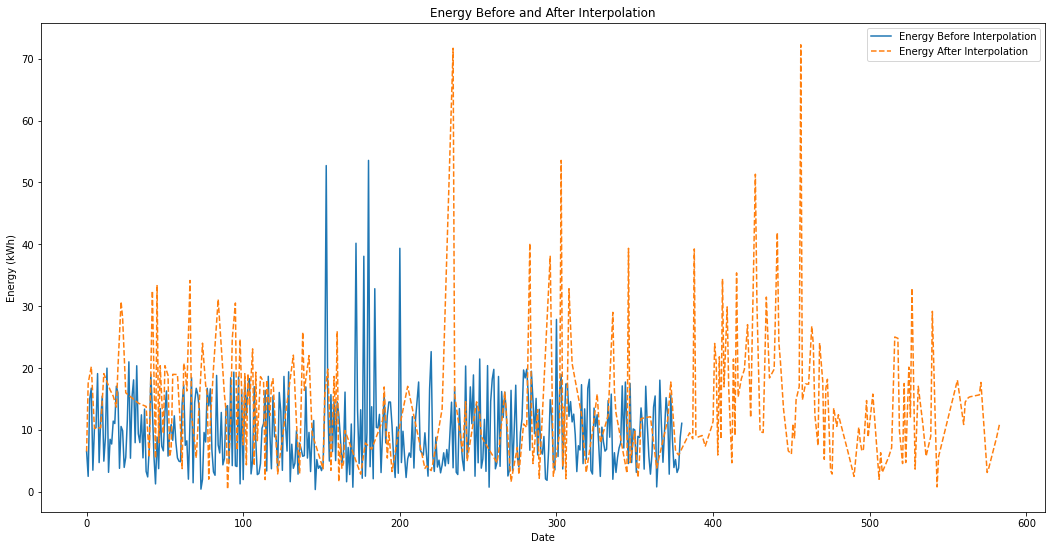

((381,), (584,))

In [31]:
energy_data1 = stations_df.loc[0, 'Transactions']['Energy__kWh_'].reset_index(drop=True)
energy_data2 = stations_daily.loc[0, 'Transactions']['Energy__kWh_'].reset_index(drop=True)

# Create a figure with a single subplot
fig, ax1 = plt.subplots(figsize=(18, 9))

# Plotting the 'Energy__kWh_' column on the first subplot
ax1.plot(energy_data1.index, energy_data1, label='Energy Before Interpolation')
ax1.plot(energy_data2.index, energy_data2, label='Energy After Interpolation', linestyle='--')

ax1.set_xlabel('Date')
ax1.set_ylabel('Energy (kWh)')
ax1.set_title('Energy Before and After Interpolation')
ax1.legend()

# Show the plot
plt.show()

energy_data1.shape, energy_data2.shape

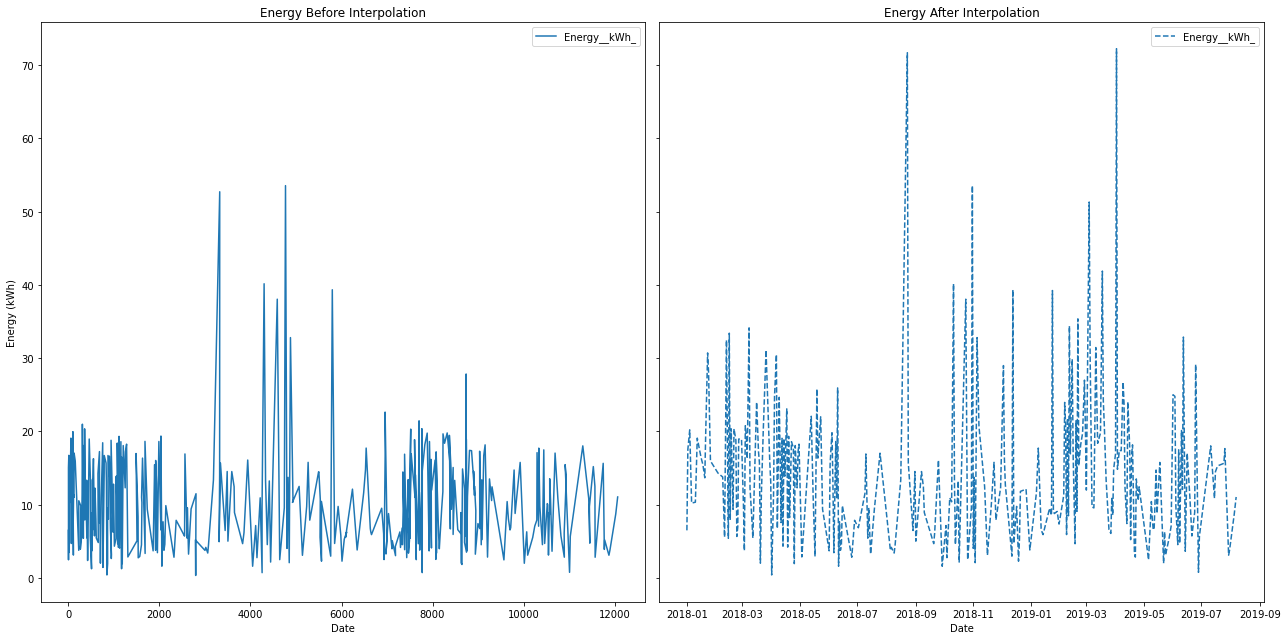

((381,), (584,))

In [32]:
energy_data1 = stations_df.loc[0, 'Transactions']['Energy__kWh_']
energy_data2 = stations_daily.loc[0, 'Transactions']['Energy__kWh_']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), sharey=True)

# Plotting the 'Energy__kWh_' column on the first subplot
ax1.plot(energy_data1.index, energy_data1, label='Energy__kWh_')
ax1.set_xlabel('Date')
ax1.set_ylabel('Energy (kWh)')
ax1.set_title('Energy Before Interpolation')
ax1.legend()

# Plotting the 'Energy__kWh_' column on the second subplot
ax2.plot(energy_data2.index, energy_data2, label='Energy__kWh_', linestyle='--')
ax2.set_xlabel('Date')
ax2.set_title('Energy After Interpolation')
ax2.legend()

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

energy_data1.shape, energy_data2.shape

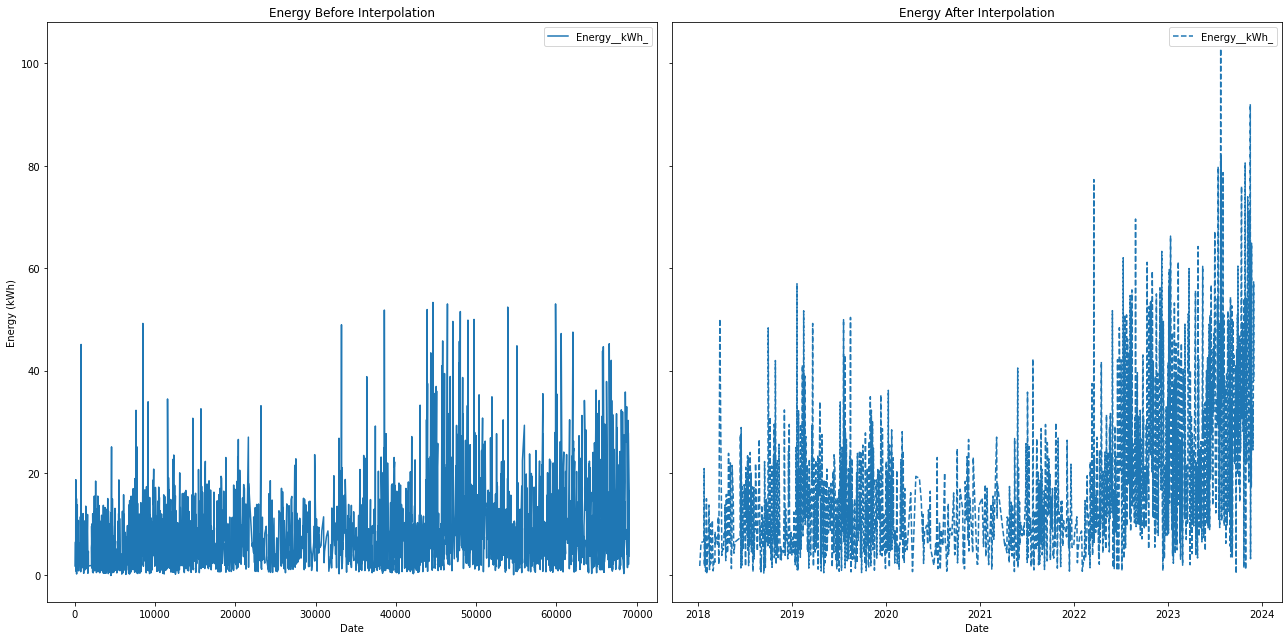

((3094,), (2155,))

In [33]:
energy_data1 = stations_df.loc[5, 'Transactions']['Energy__kWh_']
energy_data2 = stations_daily.loc[5, 'Transactions']['Energy__kWh_']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), sharey=True)

# Plotting the 'Energy__kWh_' column on the first subplot
ax1.plot(energy_data1.index, energy_data1, label='Energy__kWh_')
ax1.set_xlabel('Date')
ax1.set_ylabel('Energy (kWh)')
ax1.set_title('Energy Before Interpolation')
ax1.legend()

# Plotting the 'Energy__kWh_' column on the second subplot
ax2.plot(energy_data2.index, energy_data2, label='Energy__kWh_', linestyle='--')
ax2.set_xlabel('Date')
ax2.set_title('Energy After Interpolation')
ax2.legend()

# Adjust layout to prevent clipping of labels
plt.tight_layout()

# Show the plot
plt.show()

energy_data1.shape, energy_data2.shape

In [34]:
# So now from the smallest sizes of records 32, 77, 88, 92 
stations_daily['Transactions'].apply(lambda x: len(x)).sort_values().head(5)

37    142
33    144
38    163
21    180
36    213
Name: Transactions, dtype: int64

In [35]:
# We Check if the Transactions contains nulls
stations_daily['Transactions'].apply(lambda x: x.isna().sum()).all()

Energy__kWh_                         False
Year                                 False
Month                                False
Weekday                              False
Maximum T                            False
Minimum T                            False
Precipitation                        False
Snow                                 False
Charging_Time_min                    False
Remaining_Park_After_Charge_(min)    False
dtype: bool

In [36]:
stations_daily.to_csv('../../Dataset/MyMethod/DailyStations_Interpolated.csv', index=False)

In [37]:
# Save the DataFrame to a pickle file
stations_daily.to_pickle('../../Dataset/MyMethod/DailyStations_Interpolated.pkl')
# The to_pickle method serializes the DataFrame and stores it in a binary format
# This preserves the entire structure of the DataFrame, including nested DataFrames in the 'Transactions' column